In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '/content/drive/MyDrive/Colab Notebooks/Transfer Learning Tutorial/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [3]:
print(dataset_sizes)

{'train': 244, 'val': 153}


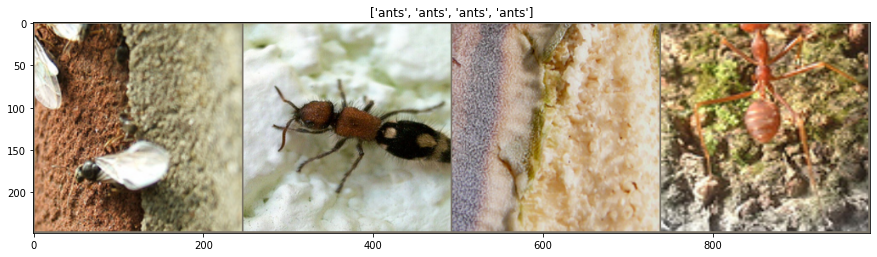

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [5]:
for i in dataloaders['train']:
    print(i[0][0])
    break 

tensor([[[-0.0458,  0.1939,  0.2967,  ..., -0.2684, -0.2856, -0.2856],
         [-0.0801,  0.1254,  0.2967,  ..., -0.2684, -0.2856, -0.2856],
         [-0.1486,  0.0398,  0.2453,  ..., -0.2513, -0.2684, -0.2856],
         ...,
         [-0.3198, -0.3198, -0.3369,  ..., -1.0219, -1.1932, -1.3644],
         [-0.2856, -0.3027, -0.3198,  ..., -0.9192, -1.0733, -1.2788],
         [-0.2856, -0.3027, -0.3198,  ..., -0.8507, -0.9877, -1.1760]],

        [[-1.8081, -1.6856, -1.4930,  ..., -0.3375, -0.3375, -0.3375],
         [-1.8256, -1.7381, -1.4930,  ..., -0.3375, -0.3375, -0.3375],
         [-1.8606, -1.7906, -1.5455,  ..., -0.3550, -0.3550, -0.3375],
         ...,
         [-0.3025, -0.3025, -0.3200,  ..., -1.2829, -1.4405, -1.6155],
         [-0.2675, -0.2850, -0.3025,  ..., -1.2129, -1.3354, -1.5455],
         [-0.2675, -0.2850, -0.3025,  ..., -1.1954, -1.2654, -1.4755]],

        [[-0.9504, -0.7238, -0.5321,  ..., -0.3230, -0.2881, -0.2881],
         [-0.9678, -0.7936, -0.5670,  ..., -0

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    losses = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for data in dataloaders[phase]:
                inputs, labels = data

                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            losses[phase].append(epoch_loss)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, losses

In [7]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        else:
            inputs, labels = inputs, labels



        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))

            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

# def visualize_model(model, num_images=6):
#     images_so_far = 0
#     fig = plt.figure()

#     for i, data in enumerate(dataloaders['val']):
#         inputs, labels = data
#         if use_gpu:
#             inputs, labels = inputs.cuda(), labels.cuda()
#         else:
#             inputs, labels = inputs, labels

#         outputs = model(inputs)
#         _, preds = torch.max(outputs.data, 1)

#         for j in range(inputs.size()[0]):
#             images_so_far += 1
#             ax = plt.subplot(num_images // 2, 2, images_so_far)
#             ax.axis('off')
#             ax.set_title('predicted: {}'.format(class_names[preds[j]]))
#             imshow(inputs.cpu().data[j])

#             if images_so_far == num_images:
#                 return

In [8]:
def evaluate(model):
    model.train(False)

    running_correct = 0
    for data in dataloaders['val']:
        inputs, labels = data

        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        else:
            inputs, labels = inputs, labels

        output = model(inputs)
        _, predicted = torch.max(output, 1)
        print(torch.sum(predicted == labels))
        
        running_correct += int(torch.sum(predicted == labels))
        
    return running_correct / dataset_sizes['val']

In [9]:
fine_tuned_model = models.alexnet(pretrained=True)

In [10]:
num_features = 4096

fine_tuned_model.classifier[6] = nn.Linear(num_features, 2)

if use_gpu:
    fine_tuned_model = fine_tuned_model.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(fine_tuned_model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [11]:
fine_tuned_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [12]:
fine_tuned_model, losses = train_model(fine_tuned_model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1987 Acc: 0.5902
val Loss: 0.1820 Acc: 0.4837

Epoch 1/24
----------
train Loss: 0.1668 Acc: 0.5697
val Loss: 0.1549 Acc: 0.6993

Epoch 2/24
----------
train Loss: 0.1533 Acc: 0.6557
val Loss: 0.1553 Acc: 0.6732

Epoch 3/24
----------
train Loss: 0.1534 Acc: 0.6393
val Loss: 0.1666 Acc: 0.6601

Epoch 4/24
----------
train Loss: 0.1455 Acc: 0.7131
val Loss: 0.1407 Acc: 0.7451

Epoch 5/24
----------
train Loss: 0.1238 Acc: 0.7869
val Loss: 0.1252 Acc: 0.7778

Epoch 6/24
----------
train Loss: 0.1309 Acc: 0.6967
val Loss: 0.0935 Acc: 0.8170

Epoch 7/24
----------
train Loss: 0.0771 Acc: 0.8443
val Loss: 0.0815 Acc: 0.8824

Epoch 8/24
----------
train Loss: 0.0727 Acc: 0.8607
val Loss: 0.0821 Acc: 0.8889

Epoch 9/24
----------
train Loss: 0.0697 Acc: 0.8689
val Loss: 0.0783 Acc: 0.8824

Epoch 10/24
----------
train Loss: 0.0493 Acc: 0.9098
val Loss: 0.0808 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.0445 Acc: 0.9057
val Loss: 0.0756 Acc: 0.8693

Ep

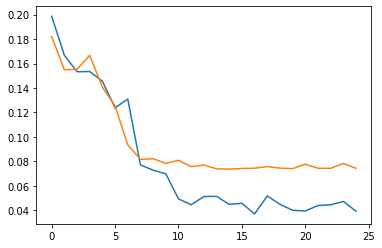

In [13]:
plt.plot(losses['train'])
plt.plot(losses['val'])

In [14]:
torch.save(fine_tuned_model.state_dict(), 'AlexNet_fine_tuned_model.pth')

In [15]:
fine_tuned_model.load_state_dict(torch.load('AlexNet_fine_tuned_model.pth'))


<All keys matched successfully>

In [16]:
print("Accuracy: {0:.4f}".format(evaluate(fine_tuned_model)))


tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(2, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(2, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
t

In [17]:
model_extractor = models.alexnet(pretrained=True)

In [18]:
for param in model_extractor.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [19]:
for param in model_extractor.features.parameters():
    param.requires_grad = False
    
num_features = 4096
model_extractor.classifier[6] = nn.Linear(num_features, 2)

if use_gpu:
    model_extractor = model_extractor.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_extractor.classifier.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [20]:
%%time
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.2171 Acc: 0.7828
val Loss: 0.3381 Acc: 0.7386

Epoch 1/24
----------
train Loss: 0.1597 Acc: 0.8730
val Loss: 0.1870 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.0927 Acc: 0.9303
val Loss: 0.1720 Acc: 0.8693

Epoch 3/24
----------
train Loss: 0.0752 Acc: 0.9303
val Loss: 0.1934 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.1120 Acc: 0.8852
val Loss: 0.2417 Acc: 0.8627

Epoch 5/24
----------
train Loss: 0.0838 Acc: 0.9016
val Loss: 0.1469 Acc: 0.8693

Epoch 6/24
----------
train Loss: 0.0531 Acc: 0.9426
val Loss: 0.1648 Acc: 0.8693

Epoch 7/24
----------
train Loss: 0.0319 Acc: 0.9344
val Loss: 0.1485 Acc: 0.8889

Epoch 8/24
----------
train Loss: 0.0206 Acc: 0.9672
val Loss: 0.1509 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.0268 Acc: 0.9549
val Loss: 0.1504 Acc: 0.8954

Epoch 10/24
----------
train Loss: 0.0250 Acc: 0.9713
val Loss: 0.1501 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.0208 Acc: 0.9672
val Loss: 0.1491 Acc: 0.8889

Ep

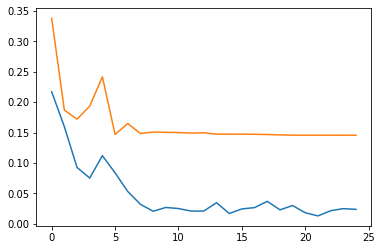

In [21]:
plt.plot(losses['train'])
plt.plot(losses['val'])

In [22]:
torch.save(model_extractor.state_dict(), 'AlexNet_extractor.pth')

In [23]:
model_extractor.load_state_dict(torch.load('AlexNet_extractor.pth'))

<All keys matched successfully>

In [24]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(2, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(2, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
t

In [25]:
model_mixed = models.alexnet(pretrained=True)

In [26]:
model_mixed

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [27]:
layers_to_unfreeze = 5
for param in model_mixed.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

num_features = 4096
model_mixed.classifier[6] = nn.Linear(num_features, 2)
if use_gpu:
    model_mixed = model_mixed.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(list(model_mixed.features.parameters())[-layers_to_unfreeze:] + 
                      list(model_mixed.classifier.parameters()), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [28]:
%%time
_, losses = train_model(model_mixed, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.1430 Acc: 0.7992
val Loss: 0.0723 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.0892 Acc: 0.8975
val Loss: 0.0950 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.0574 Acc: 0.9016
val Loss: 0.0899 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.0379 Acc: 0.9344
val Loss: 0.0959 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.0421 Acc: 0.9426
val Loss: 0.1074 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.0328 Acc: 0.9303
val Loss: 0.1258 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.0274 Acc: 0.9590
val Loss: 0.1093 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.0261 Acc: 0.9713
val Loss: 0.0996 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.0192 Acc: 0.9713
val Loss: 0.1032 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.0246 Acc: 0.9672
val Loss: 0.1067 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.0209 Acc: 0.9631
val Loss: 0.1024 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.0153 Acc: 0.9877
val Loss: 0.1003 Acc: 0.9020

Ep

In [29]:
torch.save(model_mixed.state_dict(), 'AlexNet_mixed.pth')


In [30]:
model_mixed.load_state_dict(torch.load('AlexNet_mixed.pth'))


<All keys matched successfully>

In [31]:
print("Accuracy: {0:.4f}".format(evaluate(model_mixed)))


tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(2, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(2, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
t